<a href="https://colab.research.google.com/github/mrzResearchArena/Anticancer-Peptides-CNN/blob/master/Codes/ACP-240-single-head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [1]. Google Drive Initialization:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/ACP-PyFeat'

/content/drive/My Drive/ACP-PyFeat


In [4]:
ls

bit-in-689.npy   blosum-740.npy      bpf-val-172.npy
bit-in-776.npy   blosum-in-689.npy   bpf-val-194.npy
bits-164.npy     blosum-in-776.npy   model-240.png
bits-240.npy     blosum-val-172.npy  model-240-single-head.png
bits-500.npy     blosum-val-194.npy  model-500-164.png
bits-740.npy     bpf-164.npy         model-740.png
bit-val-172.npy  bpf-240.npy         model-single-Head-500-164.png
bit-val-194.npy  bpf-500.npy         ROC-240.png
blosum-164.npy   bpf-740.npy         ROC-500-164.png
blosum-240.npy   bpf-in-689.npy      ROC-740.png
blosum-500.npy   bpf-in-776.npy      ROC.png


### [2]. Load Deep Learning API (Keras):

In [5]:
# # Initialize TF-2.x:
# try:
#     %tensorflow_version 2.x  # Colab only.
# except Exception:
#     pass

# import tensorflow as tf
# print('We\'re using TF-{}.'.format(tf.__version__))

# # Colab Auto Click: [https://paste.ubuntu.com/p/R78fGBJbjb/]

In [6]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

We're using TF-2.5.0.


In [7]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

In [8]:
def rocPlot(TPR, meanFPR):
    plt.plot([0,1], [0,1],linestyle = '--',lw = 2,color = 'black')
    meanTPR = np.mean(TPR, axis=0)
    meanAUC = auc(meanFPR, meanTPR)
    plt.plot(meanFPR, meanTPR, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (meanAUC),lw=2, alpha=1)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
    plt.legend(loc="lower right")
    plt.savefig('ROC-240.png')
    plt.show()
#end-def

### [3]. Load Datasets:

In [9]:
T = 15 # terminus_length

X1 = np.load('bpf-240.npy')
X2 = np.load('bits-240.npy')
X3 = np.load('blosum-240.npy')

X1 = X1[:,0:T,:]
X2 = X2[:,0:T,:]
X3 = X3[:,0:T,:]

Y  = [1 for _ in range(129)]
Y += [0 for _ in range(111)]
Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(240, 15, 20)
(240, 15, 31)
(240, 15, 20)
(240, 2)


In [10]:
def globalFeatureConcat(X1, X2, X3):
    V = []
    for x1,x2,x3 in zip(X1, X2, X3):
        v = np.concatenate((x1, x2, x3), axis=1)
        V.append(v)
    #end-for
    return np.array(V)

X = globalFeatureConcat(X1, X2, X3)
print(X.shape)

(240, 15, 71)


### [4]. Generate Model:

In [11]:
# Model-240

def Network():
    ### Head-1:
    input1 = Input(shape=X[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head1 = Flatten()(x)

    output = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(head1)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.80)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1], outputs=[output])
#end-def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 71)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 10)            2850      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 10)            40        
_________________________________________________________________
dropout (Dropout)            (None, 15, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 8)             248       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 8)             32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 8)             0     

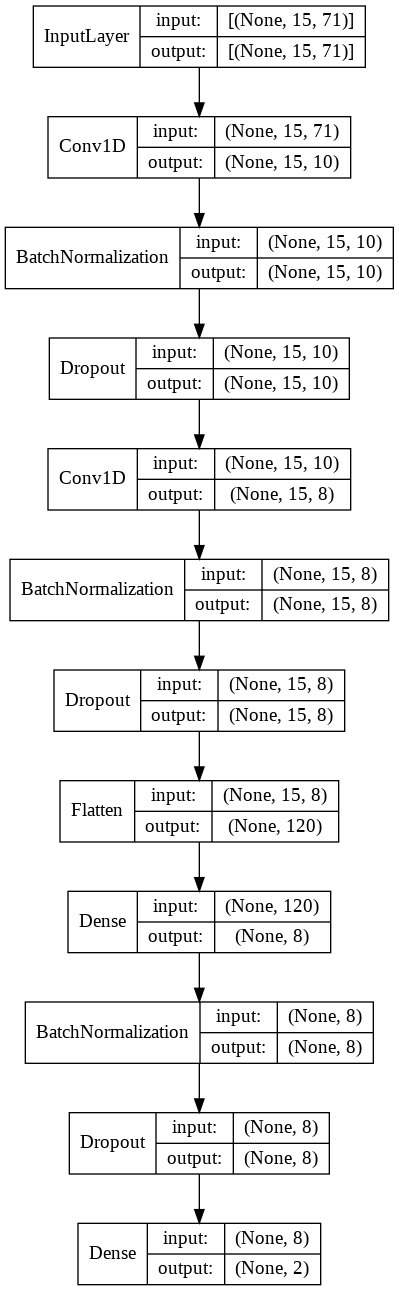

In [12]:
model = Network()
model.summary()
plot_model(model, to_file='model-240-single-head.png', show_shapes=True, show_layer_names=False, expand_nested=True)

### [5]. Run Model:

Epoch 1/500
24/24 [==============================] - 1s 13ms/step - loss: 1.8730 - accuracy: 0.5312 - val_loss: 1.1170 - val_accuracy: 0.4583
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.5893 - accuracy: 0.5208 - val_loss: 1.1188 - val_accuracy: 0.4792
Epoch 3/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2921 - accuracy: 0.4948 - val_loss: 1.0837 - val_accuracy: 0.4792
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 1.4051 - accuracy: 0.4792 - val_loss: 1.0647 - val_accuracy: 0.5208
Epoch 5/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1199 - accuracy: 0.5260 - val_loss: 1.0678 - val_accuracy: 0.5000
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1455 - accuracy: 0.5729 - val_loss: 1.0488 - val_accuracy: 0.5208
Epoch 7/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1178 - accuracy: 0.5938 - val_loss: 1.0354 - val_accuracy: 0.5208
Epoch 8/500


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


24/24 [==============================] - 1s 13ms/step - loss: 2.1438 - accuracy: 0.5000 - val_loss: 1.1799 - val_accuracy: 0.5000
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.9437 - accuracy: 0.5260 - val_loss: 1.1594 - val_accuracy: 0.4167
Epoch 3/500
24/24 [==============================] - 0s 5ms/step - loss: 1.4785 - accuracy: 0.5573 - val_loss: 1.1388 - val_accuracy: 0.4167
Epoch 4/500
24/24 [==============================] - 0s 5ms/step - loss: 1.6489 - accuracy: 0.4792 - val_loss: 1.0888 - val_accuracy: 0.5208
Epoch 5/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2963 - accuracy: 0.5677 - val_loss: 1.0647 - val_accuracy: 0.6250
Epoch 6/500
24/24 [==============================] - 0s 4ms/step - loss: 1.2560 - accuracy: 0.4740 - val_loss: 1.0459 - val_accuracy: 0.6458
Epoch 7/500
24/24 [==============================] - 0s 4ms/step - loss: 1.2763 - accuracy: 0.4792 - val_loss: 1.0419 - val_accuracy: 0.6250
Epoch 8/500
24/24 [=====

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
24/24 [==============================] - 1s 13ms/step - loss: 1.8181 - accuracy: 0.4531 - val_loss: 1.1184 - val_accuracy: 0.5000
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.5727 - accuracy: 0.5208 - val_loss: 1.0777 - val_accuracy: 0.5417
Epoch 3/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1724 - accuracy: 0.5938 - val_loss: 1.0625 - val_accuracy: 0.5000
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 1.3242 - accuracy: 0.4479 - val_loss: 1.0344 - val_accuracy: 0.5833
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 1.2208 - accuracy: 0.5208 - val_loss: 1.0545 - val_accuracy: 0.5417
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1432 - accuracy: 0.5417 - val_loss: 1.0468 - val_accuracy: 0.4167
Epoch 7/500
24/24 [==============================] - 0s 5ms/step - loss: 1.0819 - accuracy: 0.5104 - val_loss: 1.0254 - val_accuracy: 0.4792
Epoch 8/500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
24/24 [==============================] - 1s 12ms/step - loss: 1.7141 - accuracy: 0.4844 - val_loss: 1.1926 - val_accuracy: 0.4792
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.6597 - accuracy: 0.4740 - val_loss: 1.1920 - val_accuracy: 0.5417
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 1.3985 - accuracy: 0.5104 - val_loss: 1.1512 - val_accuracy: 0.4167
Epoch 4/500
24/24 [==============================] - 0s 5ms/step - loss: 1.4950 - accuracy: 0.4896 - val_loss: 1.1206 - val_accuracy: 0.4167
Epoch 5/500
24/24 [==============================] - 0s 5ms/step - loss: 1.4131 - accuracy: 0.5573 - val_loss: 1.1040 - val_accuracy: 0.4792
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2695 - accuracy: 0.5312 - val_loss: 1.0805 - val_accuracy: 0.5208
Epoch 7/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1490 - accuracy: 0.5469 - val_loss: 1.0618 - val_accuracy: 0.5417
Epoch 8/500


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
24/24 [==============================] - 1s 12ms/step - loss: 1.8797 - accuracy: 0.5052 - val_loss: 1.0692 - val_accuracy: 0.5208
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.5581 - accuracy: 0.5365 - val_loss: 1.0465 - val_accuracy: 0.5625
Epoch 3/500
24/24 [==============================] - 0s 5ms/step - loss: 1.5267 - accuracy: 0.4688 - val_loss: 1.0577 - val_accuracy: 0.5833
Epoch 4/500
24/24 [==============================] - 0s 5ms/step - loss: 1.3906 - accuracy: 0.4844 - val_loss: 1.0522 - val_accuracy: 0.5833
Epoch 5/500
24/24 [==============================] - 0s 5ms/step - loss: 1.1953 - accuracy: 0.5208 - val_loss: 1.0500 - val_accuracy: 0.5833
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 1.0776 - accuracy: 0.5833 - val_loss: 1.0367 - val_accuracy: 0.6042
Epoch 7/500
24/24 [==============================] - 0s 5ms/step - loss: 1.0764 - accuracy: 0.5104 - val_loss: 1.0275 - val_accuracy: 0.5208
Epoch 8/500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


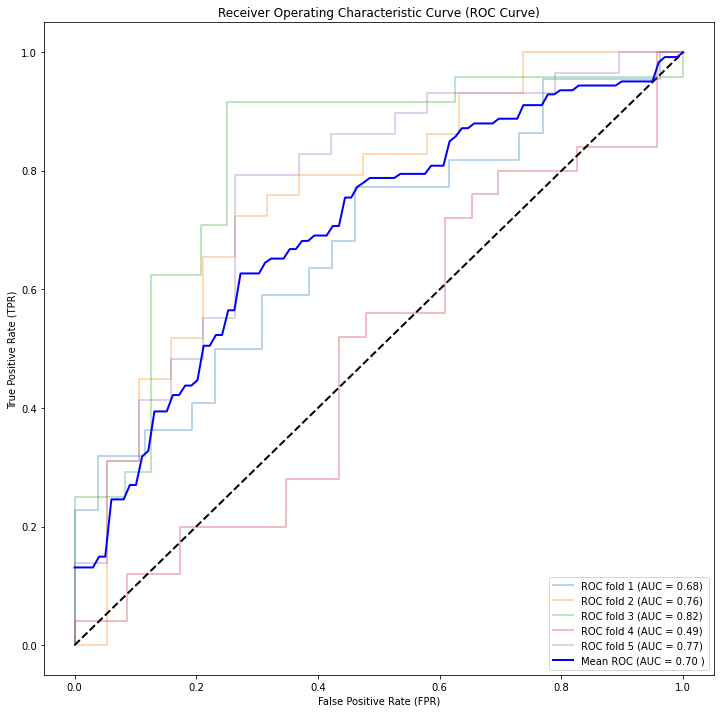

Accuracy [Each Fold]: [0.4583333432674408, 0.6875, 0.6458333134651184, 0.5208333134651184, 0.7291666865348816]
Accuracy: 0.61
Sensitivity: 0.9434
Specificity: 0.2456
MCC: 0.2243
Precision: 0.5971


In [18]:
setEpochNumber     = 500     # Performed-welled in epoch 600.
setBatchSizeNumber = 8
####################################################

cv = KFold(n_splits=5, shuffle=True, random_state=101)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# ROC Curve:
fig1 = plt.figure(figsize=[12,12])

TPR = []
meanFPR = np.linspace(0, 1, 100)

i = 1

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=X[train,:,:],
                        y=Y[train,:],
                        validation_data=(X[test,:,:], Y[test,:]),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                        verbose=1,
                        callbacks=[])
    
    accuracy = model.evaluate(x=X[test,:,:], y=Y[test,:], batch_size=setBatchSizeNumber)
    Accuracy.append(accuracy[1])

    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict(X[test,:,:])
    v = Yp
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(Yactual, v[:,1])
    TPR.append(interp(meanFPR, fpr, tpr))
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, rocauc))
    i= i+1
    
    # # Performance Plot
    # print('#################################################')
    # print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    # lossPlot(results)
    # accuracyPlot(results)
    # print('#################################################')

    
#end-for

rocPlot(TPR, meanFPR)

print('Accuracy [Each Fold]: {}'.format(Accuracy))
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))